#### Water-mass Methods Package
##### Remapping Tutorial by Taimoor Sohail

This tutorial script walks the user through the functionality of the Remapping Code within the WM_Methods package

In [1]:
## Import the BSP and Remapping components of the WM_Methods package
from WM_Methods import Remapping, BSP
## Other required packages for calculations and plotting
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In this tutorial, we demonstrate the process of creating masks which map data from watermass space onto Eulerian (3D) space. 
By providing the function the WM bin limits, and the relevant 4D distributions upon which to apply those limits, we create a 'fuzzy' mask which defines the location of that WM bin at all times provided to the code. 
These masks can then be used to map relevant bin properties onto the 3D ocean. 

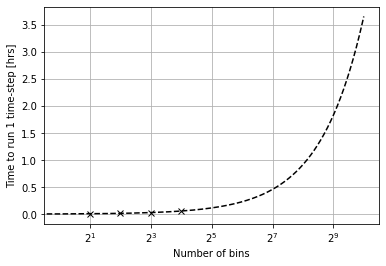

In [2]:
## Note: This code is quite slow, and regridding, masking and remapping climate data is memory intensive.
## Below we provide estimates of speed for varying tree_depths:

tdepth = 2**(np.array([1,2,3,4]))
time = np.array([27,53,103,207])/3600
plt.plot(tdepth, time,  'x', color='black')
plt.plot(np.polyval(np.polyfit(tdepth, time,1), np.arange(0,2**10)), '--k')
plt.xscale('log', base=2)
plt.xlabel('Number of bins')
plt.ylabel('Time to run 1 time-step [hrs]')
plt.grid()
plt.show()

## Given the exponential scaling with tree depth, we need to be careful about the number of time steps and bins analysed.
## We highly recommend running this function in parallel (e.g. one time-step per node) to speed up the analysis. 

In [7]:

## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_*').isel(time=slice(0,3))

T = data.Cons_Temp
S = data.Abs_Sal

## Define the watermass bounds. In this case, we create a generic set of watermass boundaries following the 
## BSP_tutorial.ipynb file

x = np.repeat(np.linspace(34,38,100)[:,np.newaxis], 100,axis=-1).flatten()
y = np.repeat(np.linspace(-3,35,100)[np.newaxis,:], 100,axis=0).flatten()
z = np.repeat(np.cos(np.linspace(np.pi*1.5,2.5*np.pi,100))[:,np.newaxis], 100,axis=-1).flatten()*\
    np.repeat(np.cos(np.linspace(np.pi*1.5,2.5*np.pi,100))[np.newaxis,:], 100,axis=0).flatten()

## For the sake of this tutorial, we keep the number of bins very low 
## (see above cell for estimates of how this code scales with # of bins)
tree_depth = 2

## Calculate the BSP bins
BSP_out = BSP.calc(x,y,z, depth=tree_depth,axis=1, mean=[x,y,z],sum=[z],weight=z)
# Split the output into constituent diagnostics
vals = BSP.split(BSP_out, depth=tree_depth)

partitions = vals['bounding_box']
## Ensure partitions match the requirements of the remap_3D function by adding a time dimension
partitions_3D = np.repeat(partitions[np.newaxis,:,:], data.time.size, axis=0)

fuzz_output = Remapping.remap_3D(T,S, partitions_3D, depth=tree_depth, zonal_int=True,\
     dims = ['time', 'lat', 'lon', 'depth'])

100%|██████████| 3/3 [02:36<00:00, 52.02s/it]


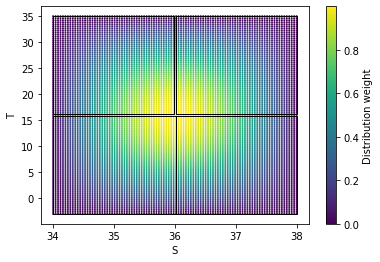

/Users/taimoor/opt/anaconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


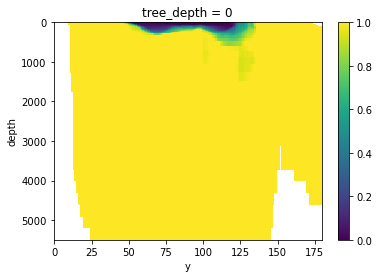

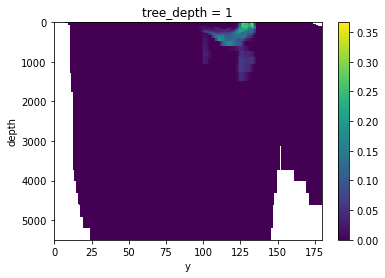

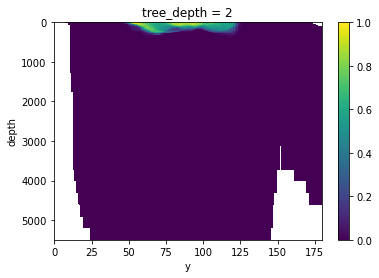

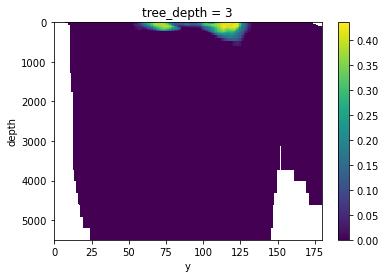

In [10]:
## Plotting the BSP bins:
BSP.draw(x,y,z,vals['bounding_box'],'black', depth=tree_depth)
cbar = plt.colorbar()
plt.xlabel('S')
plt.ylabel('T')
cbar.set_label('Distribution weight')
plt.show()

## Plotting the 2D masks for each bin
for i in range(2**tree_depth):
    (fuzz_output.isel(tree_depth=i)).plot()
    plt.gca().invert_yaxis()
    plt.show()